In [1]:
import os
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Input, Conv1D
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

2025-04-04 15:19:28.381275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743747568.516840   63731 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743747568.565988   63731 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743747568.925104   63731 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743747568.925125   63731 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743747568.925127   63731 computation_placer.cc:177] computation placer alr

In [2]:
import pickle
import os

# pickle : sequence 데이터 30개
# pickle_2 : x, y
# pickle_3 : x, y + 각도

pickle_dir = '/home/shin/deeplearning-repo-1/faa_model/pickle/'

dataset = []
labels = []
for file in os.listdir(pickle_dir):
    if file.endswith('.pkl'):
        with open(os.path.join(pickle_dir, file), 'rb') as f:
            data, label = pickle.load(f)
            dataset.extend(data)
            labels.extend(label)
            print(file, len(data))

프론트 런지.pkl 4276
스탠딩 니업.pkl 9208
스쿼트.pkl 10542
숄더프레스.pkl 3041


In [3]:
X = np.array(dataset)
y = np.array(to_categorical(labels))

X.shape, y.shape

((27067, 30, 24), (27067, 4))

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [5]:
early_stopping = EarlyStopping(
    monitor='loss',      # loss를 모니터링
    patience=5,         # 10 epoch 동안 개선 없으면 멈춤
    restore_best_weights=True # 가장 좋은 가중치 복원
)

# model = Sequential()
# model.add(LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
# model.add(Dropout(0.3))
# model.add(LSTM(64, return_sequences=False))
# model.add(Dropout(0.3))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(y.shape[1], activation='softmax'))

inputs = Input(shape=(X.shape[1], X.shape[2]))

x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(inputs)
x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)

x = LSTM(64, return_sequences=True)(inputs)
dropout1 = Dropout(0.3)(x)
attention = Attention()([dropout1, dropout1])
x = LSTM(64)(attention)
dropout2 = Dropout(0.3)(x)
x = Dense(64, activation="relu")(dropout2)
x = Dense(32, activation="relu")(x)
outputs = Dense(y.shape[1], activation="softmax")(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2025-04-04 15:19:34.904380: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-04-04 15:19:34.904402: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-04-04 15:19:34.904408: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: shin-PC
2025-04-04 15:19:34.904411: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: shin-PC
2025-04-04 15:19:34.904474: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 550.144.3
2025-04-04 15:19:34.904487: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel reported version is: 550.144.3
2025-

In [6]:
# model.fit(X_train, y_train, epochs=50, batch_size=100, callbacks=[early_stopping], validation_data=(X_val, y_val))
hist = model.fit(X_train, y_train, epochs=20, batch_size=100, validation_data=(X_val, y_val))

Epoch 1/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.6310 - loss: 0.8575 - val_accuracy: 0.8700 - val_loss: 0.3512
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9088 - loss: 0.2701 - val_accuracy: 0.8847 - val_loss: 0.3531
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9409 - loss: 0.1678 - val_accuracy: 0.9797 - val_loss: 0.0479
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9787 - loss: 0.0638 - val_accuracy: 0.9904 - val_loss: 0.0274
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9860 - loss: 0.0384 - val_accuracy: 0.9828 - val_loss: 0.0408
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9867 - loss: 0.0422 - val_accuracy: 0.9924 - val_loss: 0.0197
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9885 - loss: 0.0323 - val_accuracy: 0.9961 - val_loss: 0.0158
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9905 - loss: 0.0263 - val_acc

In [25]:
model.save('exercise_classifier_cnn.h5')

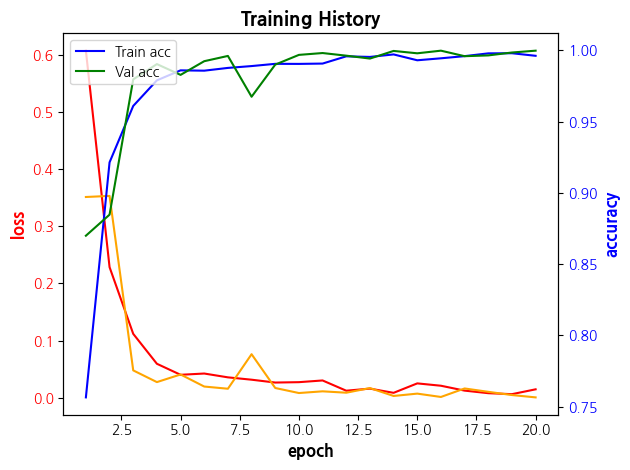

In [11]:
import matplotlib.pyplot as plt

# 데이터 추출
loss = hist.history['loss']
val_loss = hist.history['val_loss']
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(loss) + 1)

fig, ax1 = plt.subplots()

# 왼쪽 Y축 (loss)
ax1.plot(epochs, loss, color='red', label='Train loss')
ax1.plot(epochs, val_loss, color='orange', label='Val loss')
ax1.set_xlabel('epoch', fontsize=12, weight='bold')
ax1.set_ylabel('loss', color='red', fontsize=12, weight='bold')
ax1.tick_params(axis='y', labelcolor='red')

# 오른쪽 Y축 (accuracy)
ax2 = ax1.twinx()
ax2.plot(epochs, acc, color='blue', label='Train acc')
ax2.plot(epochs, val_acc, color='green', label='Val acc')
ax2.set_ylabel('accuracy', color='blue', fontsize=12, weight='bold')
ax2.tick_params(axis='y', labelcolor='blue')

# 범례
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_2, labels_2, loc='upper left')

# 제목 및 여백
plt.title('Training History', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


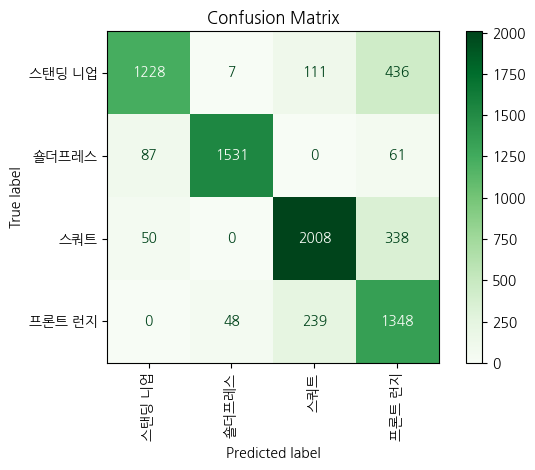

In [26]:
import pickle
import os
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import koreanize_matplotlib
from tensorflow.keras.models import load_model

dataset = []
labels = []

pkl_path = "/home/shin/deeplearning-repo-1/faa_model/valid_pickle_2/"
model_path = "exercise_classifier_cnn.h5"
label_names = ["스탠딩 니업", "숄더프레스", "스쿼트", "프론트 런지"]

# 데이터 로드
for file in os.listdir(pkl_path):
    if file.endswith('.pkl'):   
        with open(os.path.join(pkl_path, file), 'rb') as f:
            data, label = pickle.load(f)
            dataset.extend(data)
            labels.extend(label)

X = np.array(dataset) 
y_true = np.array(labels)

model = load_model(model_path)
y_pred = np.argmax(model.predict(X, verbose=0), axis=1)

fig, ax = plt.subplots()
cm = confusion_matrix(y_true, y_pred, labels=range(len(label_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(ax=ax, cmap='Greens', xticks_rotation=90)
fig.patch.set_alpha(0)     # figure 배경 투명
ax.patch.set_alpha(0)      # plot 영역 배경 투명
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

              precision    recall  f1-score   support

      스탠딩 니업     0.8996    0.6891    0.7804      1782
       숄더프레스     0.9653    0.9119    0.9378      1679
         스쿼트     0.8516    0.8381    0.8448      2396
      프론트 런지     0.6175    0.8245    0.7061      1635

    accuracy                         0.8162      7492
   macro avg     0.8335    0.8159    0.8173      7492
weighted avg     0.8374    0.8162    0.8201      7492

